In [1]:
from ultralytics import YOLO
import torch
import torchvision
from torch import nn
import torchsummary as summary
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob

In [14]:
glob.glob('D:\Pixta\data_balance\\negroid\*')

['D:\\Pixta\\data_balance\\negroid\\1010138572.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1010138573.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1014987382.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1026726112.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1026726113.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1030593212.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1030593213.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1036748462.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1036748463.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1044124232.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1044124233.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1048802842.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1048802843.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1050820142.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1050820143.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1056373722.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1056373723.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1057107092.jpg',
 'D:\\Pixta\\data_balance\\negroid\\1057107093

In [14]:
def imshow_image(img):
    num = len(img)
    print(num)
    if num == 1:
        img = img[0]
        if len(img.shape) == 3:
            img = img.unsqueeze(0)
        img = img[:,:3,:,:]
        img = img.permute(0,2,3,1).cpu()[0]
        img = img.detach().numpy()
        plt.imshow(img)
        plt.show()
    else:
        fig, ax = plt.subplots(1, num)
        for i, im in enumerate(img):
            if len(im.shape) == 3:
                im = im.unsqueeze(0)
            im = im[:,:3,:,:]
            im = im.permute(0,2,3,1).cpu()[0]
            im = im.detach().numpy()
            ax[i].imshow(im)

def plot_loss(losses):
    losses_plot = [i.cpu().detach().numpy() for i in losses]
    plt.plot(losses_plot)

def imshow_np_image(img):
    plt.imshow(img[:,:,::-1])    
    plt.show()


In [15]:
yolo = YOLO('best.pt')

In [16]:
info_label = {
    'age': ['20-30s', '40-50s', 'Baby', 'Kid', 'Senior', 'Teenager'],
    'race': ['Caucasian', 'Mongoloid', 'Negroid'],
    'masked': ['masked', 'unmasked'],
    'skintone': ['dark', 'light', 'mid-dark', 'mid-light'],
    'emotion': ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'],
    'gender': ['Female', 'Male']
}

In [17]:
def process_out_detect(img, results):
    for r in results:
        boxes = r.boxes
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 3)
            cv2.putText(img, str(i+1) ,(x1,y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 1)
        return i + 1

def sample_values(lis):
    print(lis)
    lis = list(lis)
    while len(lis) < 30:
        lis.append(-1)
    return lis

def convert_to_text(key, index):
    return info_label[key][index]

def get_label(df, name, index_box):
    name = name.replace("\\", "/")
    a = df[df['file_name'] == name]
    labels = {}
    for index, i in enumerate(a.columns):
        # if index == 0:
        #     labels[i] = a[i].values[0]
        if index >= 4:
            labels[i] = convert_to_text(i, a[i].values[index_box])
    return labels




0: 320x320 3 faces, 67.6ms
Speed: 0.0ms preprocess, 67.6ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 320)


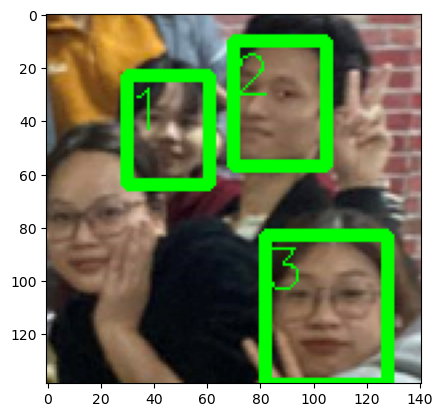

1 {'age': '20-30s', 'race': 'Mongoloid', 'masked': 'unmasked', 'skintone': 'dark', 'emotion': 'Neutral', 'gender': 'Female'}

2 {'age': '20-30s', 'race': 'Caucasian', 'masked': 'unmasked', 'skintone': 'dark', 'emotion': 'Neutral', 'gender': 'Female'}

3 {'age': '20-30s', 'race': 'Mongoloid', 'masked': 'unmasked', 'skintone': 'dark', 'emotion': 'Anger', 'gender': 'Female'}



In [18]:
def procees_out_cls(results, index_box):
    preds = {}
    num_cate = iter([6,3,2,4,7,2])
    for key in results.keys():
        cur_cate = next(num_cate)
        pred = results[key]
        pred = pred[:, (index_box * cur_cate):((index_box + 1) * cur_cate)]
        pred = torch.softmax(pred, dim= -1)
        pred = torch.argmax(pred, dim= -1)
        index = int(pred.cpu().detach().numpy())
        preds[key] = convert_to_text(key, index)
    return preds

df = pd.read_csv("D:/Pixta/encoded_labels.csv")
path = 'D:/Pixta/mnt/md0/projects/sami-hackathon/private/data/images/'

names = os.listdir(path)
np.random.shuffle(names)
preds = []
labels = []
for name in names[:1]:
    # name = '0.jpg'
    img_root = cv2.imread(name)
    # img_root = cv2.imread(path + name)
    # img_root = cv2.resize(img_root, (320,320))
    img = img_root.copy()

    results = yolo(img_root, stream= False)
    num_box = process_out_detect(img, results[0])
    imshow_np_image(img)

    for i in range(num_box):
        preds_cls = procees_out_cls(results[1], i)
        # preds.append(preds_cls)

        # labels_dict = get_label(df, name, i)
        # labels.append(labels_dict)
        print(i+1, preds_cls)
        # print(labels_dict)
        print()
# cv2.imshow('img', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()